# Load packages 

In [1]:
%matplotlib inline 
from ifis_tools import database_tools as db 
from ifis_tools import asynch_manager as am 
from ifis_tools import auxiliar as aux
from scipy import signal
from wmf import wmf
import pandas as pd 
import numpy as np 
import os 
import glob 
import pylab as pl
from string import Template
from param_ident import core 
from aclayer import core as ac

In [2]:
def cascade_values_sync(Table, param, levels, seed_values, norm_dev = 0.15):
    '''Generates a virtual setup of a watershed for a given set of values (seed_values)
    the result is updates on the cu.Table DataFrame. Contrasted with the async version, this 
    version creates values that depends on the previous level.
    Params:
        - level: the minimum orton order to distribute the seed_values.
        - param: name of the parameter in the table.
        - seed_values: a list with the initial values for the biggest horton order.
        - norm_dev: deviation aprameter to produce the random cascade.
    Resutls:
        - cu.Table[param]'''
    p = param + '7'
    Table[p] = 0.0    
    for sub, value in zip(Table['prun_7'].unique(), seed_values):
        Table.at[Table['prun_7'] == sub, p] = value

    Factors = {}
    #Iterate for each level
    for level in np.arange(6,levels-1,-1):
        
        #Initial value
        name = 'prun_'+str(level)
        p = param + str(level)
        Table[p] = Table[param + str(level+1)].copy()
        fac = []
        
        #Iterate through the sub-watersheds of each level `
        for subw in Table[name].unique():
            factor = np.random.normal(1, norm_dev)            
            Table.loc[Table[name] == subw, p] *= factor            
            fac.append(factor)
        Factors.update({str(level): fac})
    return Factors

# Get the relevant events on the watershed based on the simulations 

## Get the peaks start and end dates

In [3]:
#Reads the simulations
q = pd.read_msgpack('data/hlm_outputs/south/272677_vr4_.msg')
q = q['Q']

In [4]:
#Get peak, start and end
loc, ph = signal.find_peaks(q,50,distance=150,width=10)
qp = q.iloc[loc]
#Get the start of the event 
loc = qp.index - pd.Timedelta('150h')
qs = q.loc[loc]
#get the end of the event 
loc = qp.index + pd.Timedelta('250h')
qe = q.loc[loc]

## Get the dates of the snapshots

In [5]:
#Read the list of snapshots
L = glob.glob('data/for_hlm/south_skunk/snapshots/*')
L.sort()

#Get the dates of the snapshots
dates = [i.split('/')[-1].split('_')[-1][:-3] for i in L]
dates = pd.to_datetime(dates, unit='s')
dates = pd.DataFrame(np.arange(dates.size), index=dates, columns=['val'])

## Get the dates to use for the events

To do this, we take the dates from the start and end of each event. Then we find the nearest snapshot date for each, and those become the list of events.

In [6]:
pos_start = []
pos_end = []
for idx_start, idx_end in zip(qs.index, qe.index):
    pos_start.append(dates.index.get_loc(idx_start, method='nearest'))
    pos_end.append(dates.index.get_loc(idx_end, method='nearest'))

# Set the experiment to run the model in the dates 

Here we set up the to run the model with a random distribution of the parameters $v_0$ and $\lambda_1$ considering the following prun levels:
- 4
- 5
- 6
- Global

In [160]:
#Get the watershed
south = am.hlmModel(linkid=272678, ExtraParams=['h_order'])

#Temporal rvr to get the topology of the watershed
south.write_rvr('data/for_hlm/south_skunk/south_skunk.rvr')
topo = south.topo.copy()
topo.set_index('link_id', inplace = True)
idx = south.Table.index.intersection(topo.index)
south.Table['dest'] = topo['id'].loc[idx]

#Put the watershed in a dictionary for generalization purposes
wat = {'south': south}

#Read the table of the prun levels of the watershed.
wat['south'].Table = pd.read_csv('data/for_hlm/south_skunk/watershed_table.csv', index_col=0)

In [7]:
%load_ext fortranmagic

/Users/nicolas/.local/lib/python3.7/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [44]:
%%fortran

subroutine get_size(path,Ncontrol, Nintervals)
    !Define variables
    character*255, intent(in) :: path    
    integer,intent(out) :: Nintervals, Ncontrol
    integer i, j, Nstates
    
    !Open first time just to get the dimensions
    open(unit = 10, file = path, status = 'old', action = 'read')
    read(10,*) Ncontrol
    read(10,*) Nstates
    read(10,*)
    read(10,*) i, Nintervals
    close(10)
end subroutine


In [47]:
%%fortran
subroutine get_data(path,Ncontrol, Nintervals, control, data)
    !Define variables
    character*255, intent(in) :: path 
    integer, intent(in) ::  Nintervals, Ncontrol 
    integer,intent(out) :: control(Ncontrol)
    real, intent(out) :: data(Ncontrol,Nintervals)
    integer i, j,Nstates,oe
        
    !Open the file to read the data
    open(unit = 10, file = path, status = 'old', action = 'read')
    read(10,*) 
    read(10,*)     
    do i =1,Ncontrol
        read(10,*)
        read(10,*) control(i), oe
        do j = 1, Nintervals
            read(10,*) data(i,j)
        enddo
    enddo
    close(10)
end subroutine

In [53]:
L = glob.glob('data/for_hlm/south_skunk/out_4*.dat')
L.sort()

In [69]:
Data = []
Dates = []
for path in L:
    year = path.split('_')[-1].split('.')[0]
    Ncont, Nint = get_size(path)
    control, data = get_data(path, Ncont, Nint)
    Data.append(data)
    dates = pd.date_range(year+'-03-01 01:00', year+'-12-31 01:00', freq='1H')
    Dates.extend(dates)

In [71]:
D = np.hstack(Data)

In [72]:
D.shape

(37, 124457)

In [74]:
Df = pd.DataFrame(D.T, index=Dates, columns=control)

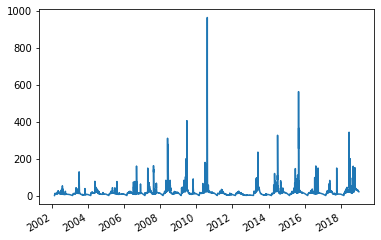

In [78]:
Df[272677].plot()